In [ ]:
import pandas as pd


In [ ]:
data = pd.read_csv('texttocsv.csv')

In [ ]:
data.head()

,text,summary
0,Ad sales boost Time Warner profitQuarterly pro...,TimeWarner said fourth quarter sales rose 2% t...
1,Dollar gains on Greenspan speechThe dollar has...,The dollar has hit its highest level against t...
2,Yukos unit buyer faces loan claimThe owners of...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profitsBritish Airwa...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts DomecqShares in UK ...,Pernod has reduced the debt it took on to fund...


In [ ]:
data.isna().sum( axis = 0)

text       0
summary    0
dtype: int64

<h2><b> Custom Attention Layer</b></h2>

In [3]:
#Importing our own custom attention layer
from attention import AttentionLayer

In [ ]:
#Importing essential libraries
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
data.columns

Index(['text', 'summary'], dtype='object')

In [ ]:
data.drop_duplicates(subset = ['text'], inplace=True)    #dropping duplicates
data.dropna(axis = 0, inplace=True)   #dropping na

In [ ]:
len(data)

2126

In [ ]:
len(data['text'])

2126

In [ ]:
len(data['summary'])

2126

<b>Preprocessing</b>

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

<h2><b>Text Cleaning</b></h2> <br>
Let’s look at the first 10 reviews in our dataset to get an idea of the text preprocessing steps:

In [ ]:
data['text'][:10]  

0    Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.The firm, which is now one o...
1    Dollar gains on Greenspan speechThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan G...
2    Yukos unit buyer faces loan claimThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.State-owned Rosneft bought the ...
3    High fuel prices hit BA's profitsBritish Airways has blamed high fuel prices for a 40% drop in profits.Reporting its results for the three months to 31 December 2004, the airline made a pre-tax pr...
4    Pernod takeover talk lifts DomecqShares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.

We will perform the below preprocessing tasks for our data:

Convert everything to lowercase 

1. Remove HTML tags 
2. Contraction mapping 
3. Remove (‘s) 
4. Remove any text inside the parenthesis 
5. Eliminate punctuations and special  
6. characters 
7. Remove stopwords 
8. Remove short words 

In [ ]:
#Cleaning the text
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.columns

Index(['text', 'summary'], dtype='object')

In [ ]:
data['summary'][:10]

0    TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn.For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09b...
1    The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.China's currency remains pegged to the dol...
2    Yukos' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets.State-owned Rosneft bought the Yugansk unit for $9.3bn in a sale forced by Russia to part...
3    Rod Eddington, BA's chief executive, said the results were "respectable" in a third quarter when fuel costs rose by £106m or 47.3%.To help offset the increased price of aviation fuel, BA last year...
4    Pernod has reduced the debt it took on to fund the Seagram purchase to just 1.8bn euros, while Allied has improved the performance of its fast-food chains.Shares in UK drinks 

In [ ]:
#Cleaning the summary
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

Adding START and END special tokens at the beginning and end of the summary:

In [ ]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: sales boost time warner profitquarterly profits media giant timewarner jumped three months december year earlier firm one biggest investors google benefited sales high speed internet connections higher advert sales timewarner said fourth quarter sales rose profits buoyed one gains offset profit dip warner bros less users aol time warner said friday owns search engine google internet business aol mixed fortunes lost subscribers fourth quarter profits lower preceding three quarters however company said aol underlying profit exceptional items rose back stronger internet advertising revenues hopes increase subscribers offering online service free timewarner internet customers try sign aol existing customers high speed broadband timewarner also restate results following probe securities exchange commission close concluding time warner fourth quarter profits slightly better analysts expectations film division saw profits slump helped box office flops alexander catwoman sharp contrast

<h3><b>Understanding the distribution of the sequences</b></h3> <br>
<b>Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text.</b><br>
This will help us fix the maximum length of the sequence:

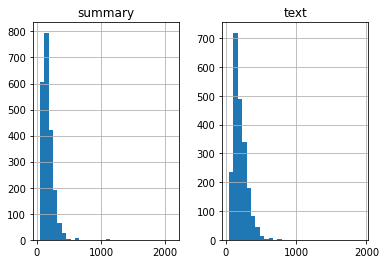

In [ ]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
data.columns

Index(['text', 'summary', 'cleaned_text', 'cleaned_summary'], dtype='object')

In [ ]:
print(text_word_count)

[236, 218, 155, 231, 156, 109, 164, 177, 136, 128, 103, 175, 174, 274, 335, 130, 120, 97, 163, 357, 201, 183, 119, 178, 249, 172, 149, 127, 225, 234, 185, 169, 119, 177, 121, 191, 222, 93, 120, 132, 196, 127, 119, 229, 177, 168, 143, 148, 326, 191, 173, 271, 123, 146, 173, 147, 256, 113, 170, 90, 128, 171, 164, 166, 178, 194, 166, 237, 274, 117, 130, 155, 140, 150, 120, 165, 266, 139, 145, 134, 150, 113, 275, 116, 137, 107, 169, 104, 190, 222, 184, 207, 152, 111, 141, 92, 241, 123, 252, 188, 201, 124, 271, 216, 124, 174, 170, 95, 72, 154, 306, 173, 212, 185, 116, 135, 250, 119, 284, 171, 297, 226, 106, 101, 125, 202, 262, 181, 98, 242, 272, 126, 165, 205, 220, 297, 126, 178, 180, 266, 145, 187, 140, 99, 156, 464, 124, 150, 325, 210, 162, 185, 205, 207, 161, 161, 143, 85, 345, 196, 219, 175, 253, 235, 217, 136, 126, 142, 111, 122, 118, 234, 217, 152, 132, 159, 192, 154, 119, 189, 277, 157, 413, 190, 177, 130, 175, 243, 235, 179, 271, 215, 173, 105, 224, 165, 151, 156, 187, 356, 157, 218

In [ ]:
data1 = pd.Series(data = text_word_count)

In [ ]:
 #Getting the frequency of words in text to set the maximum words present in text
data1.value_counts() 

130    19
156    19
145    17
152    17
127    17
       ..
486     1
476     1
474     1
468     1
60      1
Length: 403, dtype: int64

In [ ]:
max_len_text = 180 

In [ ]:
data.columns

Index(['text', 'summary', 'cleaned_text', 'cleaned_summary'], dtype='object')

In [ ]:
data2 = pd.Series(data = summary_word_count)

In [ ]:
#Getting the frequency of words in summary to set the maximum words present in summary
data2.value_counts()

90      22
126     20
103     20
101     20
133     19
        ..
460      1
486      1
530      1
1515     1
598      1
Length: 336, dtype: int64

In [ ]:
max_len_summary = 90

In [ ]:
data['cleaned_text']

0       sales boost time warner profitquarterly profits media giant timewarner jumped three months december year earlier firm one biggest investors google benefited sales high speed internet connections h...
1       dollar gains greenspan speechthe dollar hit highest level euro almost three months federal reserve head said trade deficit set stabilise alan greenspan highlighted government willingness curb spen...
2       yukos unit buyer faces loan claimthe owners embattled russian oil giant yukos ask buyer former production unit pay back loan state owned rosneft bought yugansk unit sale forced russia part settle ...
3       high fuel prices hit profitsbritish airways blamed high fuel prices drop profits reporting results three months december airline made pre tax profit compared year earlier rod eddington chief execu...
4       pernod takeover talk lifts domecqshares drinks food firm allied domecq risen speculation could target takeover france pernod ricard reports wall street journal 

In [ ]:
#Splitting the data
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 


<h3><b>Preparing the Tokenizer</b></h3><br>
A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

In [ ]:
#prepare a tokenizer for text on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:

#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1